In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares

## Introduction
In this notebook, you will learn how to fit light curves of gravitational microlensing events. Microlensing occurs when the light from a distant star (known as a source) is bent and magnified in the gravitational field of an intervening lensing object (lens). An observer on Earth can detect a brief transient brightening of the otherwise constant source star. Microlensing events are detected mostly toward the Galactic center and disk.

In this tutorial, we will model the light curve of microlensing event ZTF19aavisrq that was detected by ZTF.

In [2]:
# Reading data from a text file

time, mag, magerr = np.loadtxt('img/ZTF19aavisrq.dat', unpack=True, usecols=(0, 1, 2))
time -= 2450000.0

<IPython.core.display.Javascript object>


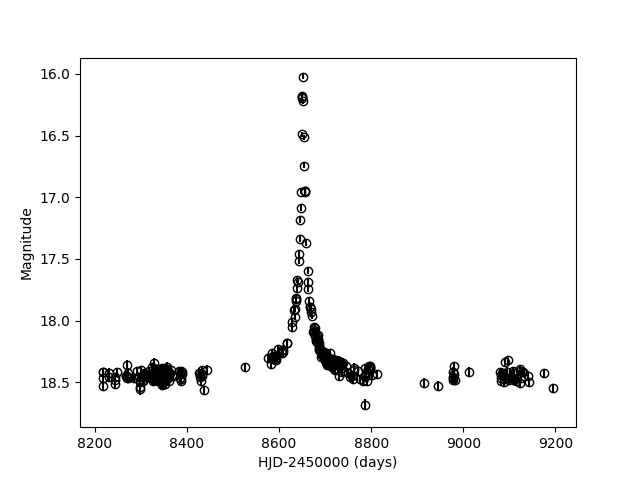

In [3]:
fig, ax = plt.subplots()
ax.errorbar(time, mag, magerr, fmt='o', mfc='none', color='k')
ax.invert_yaxis()
ax.set_xlabel('HJD-2450000 (days)')
ax.set_ylabel('Magnitude')
plt.show()

Every microlensing event has a characteristic angular scale, which we call the angular Einstein radius $\theta_E$. The Einstein radius depends on the mass of the lens $M$, the distance of the lens $d_L$, and the distance to the source $d_S$:
$$
\theta_E = \sqrt{\frac{4GM}{c^2}\frac{d_S-d_L}{d_S d_L}}.
$$
Calculate the Einstein radius for a typical lens that has a mass of $0.5\,M_{\odot}$ and is located 4 kpc from the observer. Assume that the source star is located in the Galactic bulge at 8 kpc.

In [ ]:
# ....

In the simplest case, when the lens is an isolated object and the source star can be regarded as a point, the magnification of the source depends on the lens-source separation $\theta$ scaled to $\theta_E$:
$$
A(u) = \frac{u^2+2}{u\sqrt{u^2+4}},
$$
where $u=\theta/\theta_E$. This function has several important properties. $A(u)$ is always greater than 1, so microlensing can only increase the brightness of the source star, not decrease it. $A(u)$ always decreases as $u$ increases, so the closer the alignment, the brighter the source becomes. As $u$ approaches infinity, $A(u)$ approaches 1, so that at wide separations, microlensing has no effect. Finally, as $u$ approaches 0, for a point source $A(u)$ approaches infinity as the images approach an Einstein ring. 

The lens-source separation $u$ varies with time. The function $u(t)$ can be determined by the Pythagorean theorem:
$$
u(t) = \sqrt{u_0^2 + \tau(t)^2} = \sqrt{u_0^2+\left(\frac{t-t_0}{t_E}\right)^2},
$$
where $u_0$ is the minimum lens-source separation, $t_0$ is the time of the peak, and $t_E$ is called the Einstein time. $t_E$ is the time it takes the lens to transverse an angular distance $\theta_E$ relative to the source.

![title](img/geom_Aofu.png)

The amplitude of the event depends on the impact parameter $u_0$. Plot the function $u_0=u_0(A_{\rm max})$.

In [ ]:
# ...

Our lensing model has three parameters: $t_0$ -- time of the peak, $t_E$ -- Einstein timescale, and $u_0$ -- impact parameter. There are two auxialiary parameters: $F_s$ -- flux of the source star (that is magnified during the event) and $F_b$ -- blended flux, which may come from unrelated unresolved stars and/or the lens itself. The blend flux is not magnified during the event. The total flux is:
$$
F(t) = F_s A(t; t_0,t_E,u_0) + F_b.
$$

We will find the best-fit parameters by minimizing the function $\chi^2$, which is the sum of squares of residuals between the observations and model predictions:
$$
\chi^2 = \sum_{i=1}^N \frac{(F_i-F(t_i))^2}{\sigma_i^2} = \sum_{i=1}^N \frac{(F_i-F_s A(t_i;t_0,t_E,u_0)-F_b)^2}{\sigma_i^2}
$$

Our model is linear in $F_s$ and $F_b$. This means that for every set of $(t_0,t_E,u_0)$, we can directly find $F_s$ and $F_b$ that minimize $\chi^2$. We require:
$$
\frac{\partial\chi^2}{\partial F_s} = 0\ \mathrm{and} \ \frac{\partial\chi^2}{\partial F_b} = 0.
$$

Thus (you can prove that!):
$$
F_s \sum_{i=1}^N \frac{A(t_i)^2}{\sigma_i^2} + F_b \sum_{i=1}^N \frac{A(t_i)}{\sigma_i^2} = \sum_{i=1}^N \frac{A(t_i)F_i}{\sigma_i^2}\\
F_s \sum_{i=1}^N \frac{A(t_i)}{\sigma_i^2} + F_b \sum_{i=1}^N \frac{1}{\sigma_i^2} = \sum_{i=1}^N \frac{F_i}{\sigma_i^2}\\
$$

We now have all ingredients needed to code the function $\chi^2$.

In [4]:
def amplification(params, time):
    assert len(params) == 3
    t_0, t_E, u_0 = params
    tau = (time-t_0)/t_E
    u = np.sqrt(tau*tau + u_0*u_0)
    A = (u*u+2.0)/u/np.sqrt(u*u+4.0)
    return A

def get_fluxes(params, time, flux, flux_err):
    A = amplification(params, time)
    weight = 1.0/(flux_err*flux_err)
    sum1 = np.sum(A*A*weight)
    sum2 = np.sum(A*weight)
    sum3 = np.sum(weight)
    sum4 = np.sum(A*flux*weight)
    sum5 = np.sum(flux*weight)
    F = np.linalg.solve([[sum1, sum2], [sum2, sum3]], [sum4, sum5])
    residuals = (flux-F[0]*A-F[1])/flux_err
    chi_squared = np.sum(residuals*residuals)
    return chi_squared, F, residuals

def chi2(params, time, flux, flux_err):
    chi_squared, F, residuals = get_fluxes(params, time, flux, flux_err)
    return chi_squared

## $\chi^2$ minimization with the Nelder-Mead algorithm
Let's fit some data! First, we need to convert magnitudes to flux. We use the Pogson law and assume that a unit flux corresponds to a 18 mag object.

In [5]:
flux = pow(10.0, 0.4*(18.0-mag))
flux_err = 0.4*np.log(10.0)*flux*magerr

We now use scipy's minimize function to find ($t_0,t_E,u_0$) that minimize our $\chi^2$ function. We have to choose initial guess parameters. For example, for $t_0=8652$, $t_E=50$ days and $u_0=0.05$, we get $\chi^2=1233.2$.

In [7]:
params0 = np.array([8652., 50., 0.05])
chi_sq = chi2(params0, time, flux, flux_err)
print(chi_sq)

1233.1875593077625


In [8]:
res = minimize(
    chi2,  # function to be minimized
    params0,  # initial guess
    args=(time, flux, flux_err),  # extra arguments passed to the objective function
    method='Nelder-Mead',  # minimization algorithm
)

print(res)

 final_simplex: (array([[8.65181355e+03, 8.91671423e+01, 1.78801632e-02],
       [8.65181355e+03, 8.91672147e+01, 1.78801449e-02],
       [8.65181355e+03, 8.91671120e+01, 1.78801730e-02],
       [8.65181355e+03, 8.91671877e+01, 1.78801450e-02]]), array([464.11562406, 464.11562406, 464.11562406, 464.11562406]))
           fun: 464.11562405801016
       message: 'Optimization terminated successfully.'
          nfev: 237
           nit: 127
        status: 0
       success: True
             x: array([8.65181355e+03, 8.91671423e+01, 1.78801632e-02])


Let's plot the best-fitting model

[0.10011119 0.56057475]


<IPython.core.display.Javascript object>


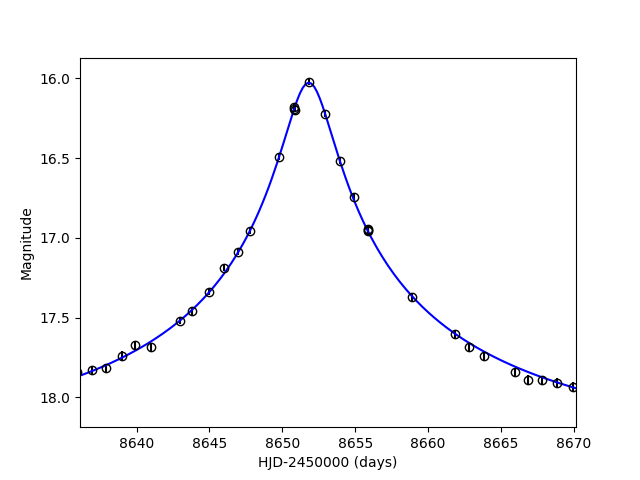

In [9]:
# get source and blend fluxes:
chi_sq, F, residuals = get_fluxes(res.x, time, flux, flux_err)
print(F)

time_model = np.linspace(time[0], time[-1], 5000)
A_model = amplification(res.x, time_model)
flux_model = F[0]*A_model + F[1]
mag_model = 18.0 - 2.5*np.log10(flux_model)

fig, ax = plt.subplots()
ax.errorbar(time, mag, magerr, fmt='o', mfc='none', color='k')
ax.plot(time_model, mag_model, color='blue')
ax.invert_yaxis()
ax.set_xlabel('HJD-2450000 (days)')
ax.set_ylabel('Magnitude')
plt.show()

## Using least-squares methods
The minimization can be also performed using the least squares method. We'll use the Levenberg-Marquardt algorithm as an example, but we have to modify our objective function.

In [15]:
def get_residuals(params, time, flux, flux_err):
    chi_squared, F, residuals = get_fluxes(params, time, flux, flux_err)
    return residuals

ls_res = least_squares(
    get_residuals,
    params0,
    method='lm',
    args=(time, flux, flux_err),
)

print(ls_res)

 active_mask: array([0, 0, 0])
        cost: 232.05781202905908
         fun: array([-2.25523818e+00,  8.87369774e-01,  8.87252238e-01, -4.33460205e-01,
        7.53111780e-01, -1.26615284e-01, -1.84536536e-01, -1.71366246e+00,
       -8.11648604e-01,  9.38636951e-01,  8.97115167e-02,  6.15811103e-02,
        2.62714218e+00, -4.70170375e-01,  3.00874627e-02, -1.90826647e-01,
        7.95239790e-01, -1.17421693e-01, -3.88273843e-01, -3.32723509e-01,
        1.06752424e+00, -2.51872974e-01, -1.29932828e+00, -8.51362621e-01,
       -2.61645496e+00, -2.10784172e+00,  1.28483464e+00,  1.07941177e-01,
       -8.81023948e-01, -1.07687049e+00,  6.27969747e-01,  2.98402861e-01,
       -2.85151348e-01, -3.52729945e-02,  1.05910885e+00, -3.52021773e-01,
        2.03403865e+00,  7.30405490e-01, -1.02835209e+00, -1.50764915e-01,
        3.74612089e-01, -4.03936714e-01,  2.71852288e+00, -7.02969218e-01,
       -7.79390014e-01,  1.60071338e+00,  4.18649667e-02,  1.10801442e+00,
        6.78603993e-01

Note that this function converges much more quickly that the $\chi^2$ minimization algorithm (Nelder-Mead algorithm). It required only 30 evaluations of the objective function (whereas the Nelder-Mead algorithm needed 237 function evaluations!) If the calculation of the objective function is computationally costly, least-squares method are much more quicker! You can test other algorithms by changing the method argument: Trust Region Reflective algorithm (method='trf') and dogleg algorithm (method='dogbox'). You can also speed up calculations by providing the Jacobian matrix.

## Uncertainties
We will use the Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler coded by Foreman-Mackey et al. to measure parameter uncertainties

In [16]:
import emcee
import corner

In [17]:
def log_prior(params):
    if params[1] < 0:
        return -np.inf
    if params[2] < 0:
        return -np.inf
    return 0.0

def log_prob(params, time, flux, flux_err):
    chi_squared, F, residuals = get_fluxes(params, time, flux, flux_err)
    prior = log_prior(params)
    if np.isinf(prior):
        return -np.inf
    return -0.5*chi_squared + prior

In [18]:
ndim = 3  # number of dimensions
nwalkers = 100  # number of walkers
nburnin = 3000
nsteps = 2000

p0 = np.random.multivariate_normal(res.x, cov=np.diag([1.0, 5.0, 0.00001]), size=nwalkers)

In [19]:
sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    log_prob,
    args=[time, flux, flux_err]
)

In [20]:
state = sampler.run_mcmc(p0, nburnin)
sampler.reset()

In [21]:
state = sampler.run_mcmc(state, nsteps)

In [22]:
samples = sampler.get_chain(flat=True)

<IPython.core.display.Javascript object>


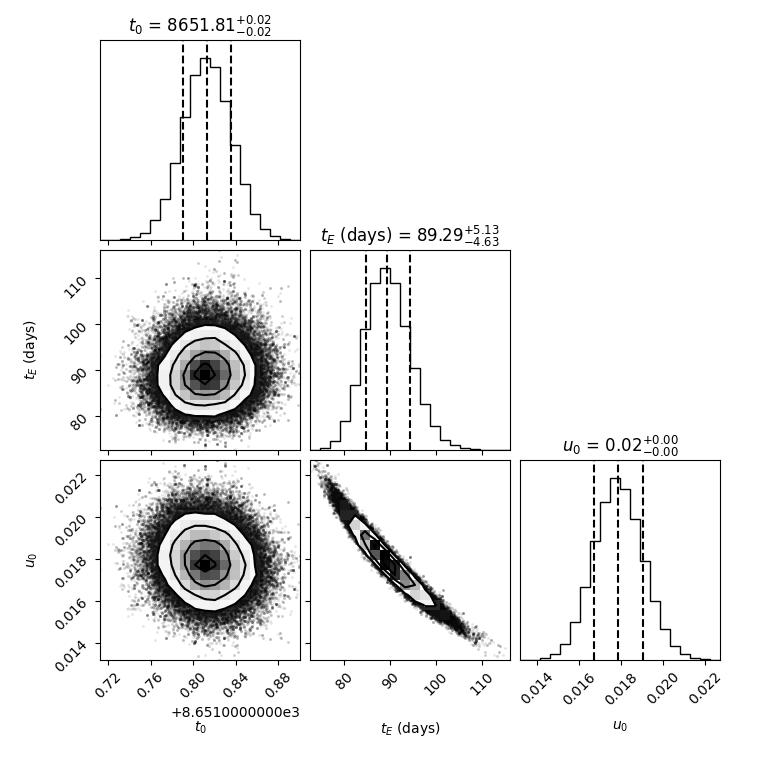

In [24]:
labels = ['$t_0$', '$t_E$ (days)', '$u_0$']

corner.corner(
    samples,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
)
plt.show()